In [20]:
import pycbc
from pycbc.filter.matchedfilter import sigma, matched_filter
from pycbc.psd import aLIGOZeroDetHighPower, AdvVirgo
from pycbc.waveform import get_td_waveform, get_fd_waveform
import numpy as np
import pylab as plt
from pycbc import conversions as convert
from pesummary.gw.conversions.spins import component_spins
from pycbc.detector import Detector

## Signal parameters

In [8]:
pi = np.pi
mass1 = 30
mass2 = 20
theta_jn = pi/3
phi_jl = pi/4
tilt_1 = pi/3
tilt_2 = pi/6
phi_12 = pi/3
a_1 = 0.6
a_2 = 0.5
f_ref = 20
coa_phase = 0
iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = component_spins(theta_jn, 
                                                                       phi_jl, 
                                                                       tilt_1, 
                                                                       tilt_2, 
                                                                       phi_12, 
                                                                       a_1, 
                                                                       a_2, 
                                                                       mass1, 
                                                                       mass2, 
                                                                       f_ref, 
                                                                       coa_phase)

## Generate waveform in time domain

In [27]:
sample_rate = 1024
hpt, hct = get_td_waveform(approximant = 'IMRPhenomXPHM', f_lower = 20, delta_t = 1/sample_rate, 
                           mass1 = mass1, mass2 = mass2,
                           distance = 500, inclination = iota, coa_phase = coa_phase,
                           spin1x = spin1x, spin2x = spin2x, 
                           spin1y = spin1y, spin2y = spin2y, 
                           spin1z = spin1z, spin2z = spin2z)

Text(0, 0.5, 'strain')

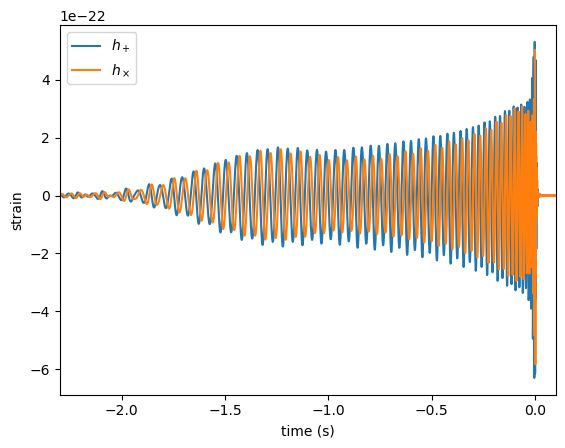

In [28]:
# Plot the waveform

plt.plot(hpt.sample_times, hpt, label='$h_+$')
plt.plot(hpt.sample_times, hct, label='$h_\\times$')
plt.xlim(-2.3, 0.1)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('strain')

## Generate waveform in frequency domain

In [44]:
hpf, hcf = get_fd_waveform(approximant = 'IMRPhenomXPHM', f_lower = 20, delta_f = 0.01, 
                           mass1 = mass1, mass2 = mass2,
                           distance = 500, inclination = iota, coa_phase = coa_phase,
                           spin1x = spin1x, spin2x = spin2x, 
                           spin1y = spin1y, spin2y = spin2y, 
                           spin1z = spin1z, spin2z = spin2z)

Text(0, 0.5, 'amplitude')

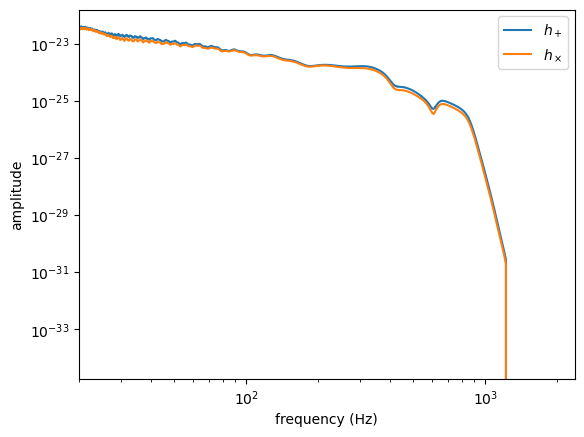

In [31]:
plt.loglog(hpf.sample_frequencies, abs(hpf), label='$h_+$')
plt.loglog(hcf.sample_frequencies, abs(hcf), label='$h_\\times$')
plt.xlim(20, )
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude')

Text(0, 0.5, 'phase')

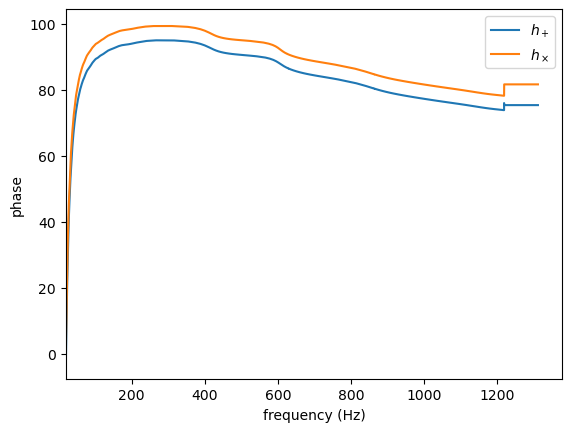

In [33]:
plt.plot(hpf.sample_frequencies, np.unwrap(np.angle(hpf)), label='$h_+$')
plt.plot(hcf.sample_frequencies, np.unwrap(np.angle(hcf)), label='$h_\\times$')
plt.xlim(20, )
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('phase')

## Project signal on the detector

In [34]:
trigger_time = 123456789
ra = 0
dec = 0
polarization = 0

In [50]:
detectors = ['L1', 'H1', 'V1', 'C1']
ht = {}
for det in detectors:
    d = Detector(det)
    ht[det] = d.project_wave(hpt, hct, ra, dec, polarization)

## Assign PSDs to the detectors

In [55]:
psds = {
    'L1': aLIGOZeroDetHighPower(len(ht['L1']), delta_f=ht['L1'].delta_f, low_freq_cutoff=20),
    'H1': aLIGOZeroDetHighPower(len(ht['H1']), delta_f=ht['H1'].delta_f, low_freq_cutoff=20),
    'V1': AdvVirgo(len(ht['V1']), delta_f=ht['V1'].delta_f, low_freq_cutoff=20),
    
    # To add PSD from a PSD file
    'C1': pycbc.psd.read.from_txt('CE40-psd.txt', len(ht['C1']), ht['C1'].delta_f, 5, is_asd_file=False)
}

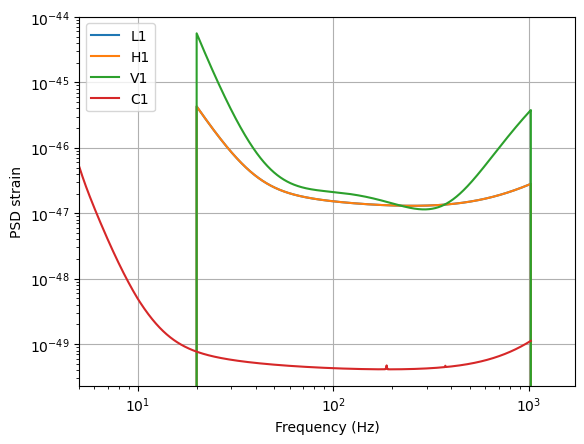

In [61]:
for det in detectors:
    plt.loglog(psds[det].sample_frequencies, psds[det], label=det)
plt.legend()
plt.xlim(5,)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD strain')
plt.grid()

## Calculate optimal SNR

In [56]:
snrs = {}
snr_netw_sq = 0
for det in detectors:
    snrs[det] = sigma(ht[det], psd=psds[det], low_frequency_cutoff=20)
    snr_netw_sq += snrs[det]**2
snrs['network'] = np.sqrt(snr_netw_sq)

In [57]:
snrs

{'L1': 32.61694299308807,
 'H1': 26.383762914503574,
 'V1': 14.310006144804262,
 'C1': 872.5363647698855,
 'network': 873.6615202911561}

## Matched filtering with real GW signal

Text(0.5, 0, 'GPS Time (s)')

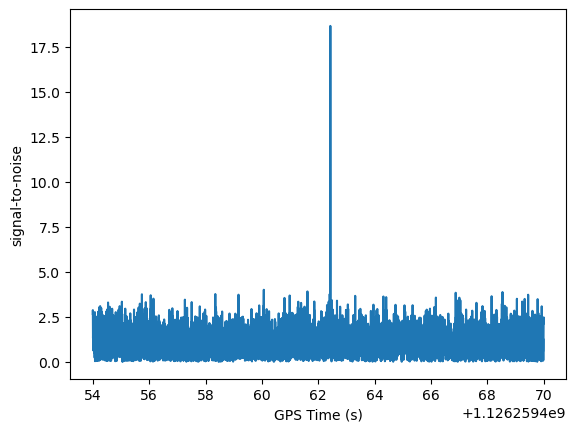

In [49]:
import matplotlib.pyplot as pp
from urllib.request import urlretrieve
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate


# Read data and remove low frequency content
fname = 'H-H1_LOSC_4_V2-1126259446-32.gwf'
url = "https://www.gwosc.org/GW150914data/" + fname
urlretrieve(url, filename=fname)
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 8)

# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h1.duration)

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                         f_lower=20, delta_f=1.0/h1.duration)
hp.resize(len(h1) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pp.plot(snr.sample_times, abs(snr))
pp.ylabel('signal-to-noise')
pp.xlabel('GPS Time (s)')